EMOTION DETECTOR

IMPORTING LIBRARIES

In [1]:
import matplotlib.pyplot as plt
from glob import glob
import cv2
import random
import os
%matplotlib inline

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten ,Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation ,MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

from IPython.display import SVG ,Image
import tensorflow as tf
print("tensorflow version: ",tf.__version__)



/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


tensorflow version:  2.13.0


EXPLORING DATASETS

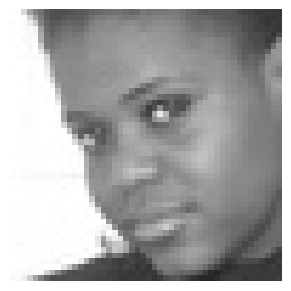

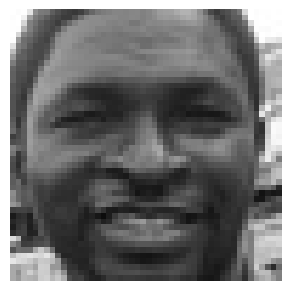

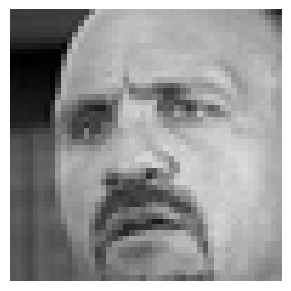

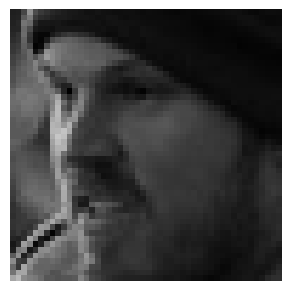

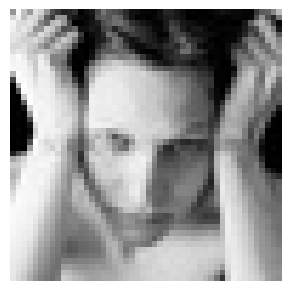

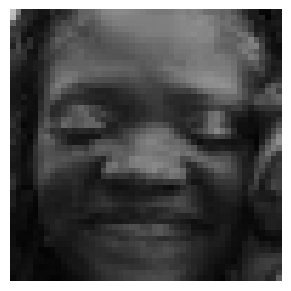

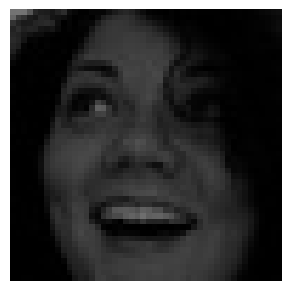

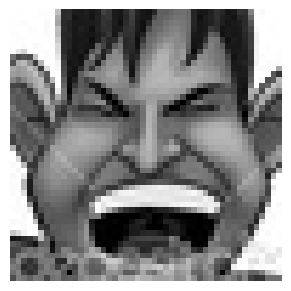

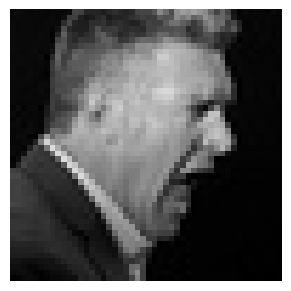

In [9]:
from pathlib import Path
import cv2
import matplotlib.pyplot as plt
import random

# Path to the directory containing image files
data_dir = Path("/kaggle/input/face-expression-recognition-dataset/")

# Fetch image paths using specific file extensions
image_paths = list(data_dir.glob("**/*.jpg"))  # Update file extension as needed

# Display random images
for i in range(9):
    image_path = random.choice(image_paths)
    image = cv2.imread(str(image_path))
    
    # Check if the image is loaded successfully
    if image is not None:
        plt.figure(figsize=(12, 12))
        plt.subplot(331 + i)
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB
        plt.axis('off')
    else:
        print(f"Failed to load image: {image_path}")

plt.show()


PREPARING DATA FOR TRAINING

In [13]:
from keras.preprocessing.image import ImageDataGenerator

img_size = 48
batch_size = 64

datagen_train = ImageDataGenerator(horizontal_flip=True)
train_generator = datagen_train.flow_from_directory(
    "/kaggle/input/face-expression-recognition-dataset/images/train",
    target_size=(img_size, img_size),
    color_mode="grayscale",
    batch_size=batch_size,
    class_mode="categorical",  # This should be categorical for multiple classes
    shuffle=True
)

datagen_validation = ImageDataGenerator(horizontal_flip=True)
validation_generator = datagen_validation.flow_from_directory(
    "/kaggle/input/face-expression-recognition-dataset/images/validation",
    target_size=(img_size, img_size),
    color_mode="grayscale",
    batch_size=batch_size,
    class_mode="categorical",  # This should be categorical for multiple classes
    shuffle=True
)


Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


DEFINING MODEL

In [14]:
def Convolution(input_tensor,filters,kernel_size ):
    x= Conv2D(filters= filters, kernel_size= kernel_size, padding= "same")(input_tensor)
    x= BatchNormalization()(x)
    x= Activation('relu')(x)
    x= MaxPooling2D(pool_size=(2,2))(x)
    x= Dropout(0.25)(x)
    return x

In [15]:
def Dense_f (input_tensor, nodes):
    x= Dense(nodes)(input_tensor)
    x= BatchNormalization()(x)
    x= Activation('relu')(x)
    x= Dropout(0.25)(x)
    return x
    

In [16]:
def model_fer(input_shape):
    inputs= Input(input_shape)
    conv_1 =Convolution(inputs,64,(3,3))
    conv_2 =Convolution(conv_1,128,(5,5))
    conv_3 =Convolution(conv_2,512,(3,3))
    conv_4 =Convolution(conv_2,512,(3,3))

    flatten = Flatten()(conv_4)
    dense_1 = Dense_f(flatten,256)
    dense_2 = Dense_f(dense_1,512)
    output = Dense(7,activation= "softmax")(dense_2)
    model = Model(inputs= [inputs], outputs= [output])
    opt = Adam(lr=0.0005)
    model.compile(loss= ['categorical_crossentropy'],optimizer = 'adam', metrics = ['accuracy'])
    
    return model

In [17]:
model= model_fer((48,48,1))
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 batch_normalization (Batch  (None, 48, 48, 64)        256       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0     

INITIALISING MODEL

In [19]:
epochs = 15
steps_per_epoch = train_generator.n // train_generator.batch_size
validation_steps = validation_generator.n // validation_generator.batch_size
checkpoint = ModelCheckpoint("model_weights.h5", monitor = 'val_accuracy', save_weights_only = True, mode = 'max', verbose = 1)
reduce_lr= ReduceLROnPlateau(monitor='val_loss', factor= 0.1, patience=2 , min_lr = 0.00001)
callbacks = [checkpoint,reduce_lr]

TRAINING THE MODEL

THE NEXT CELL TAKES TIME TO COMPLETE

In [20]:
history = model.fit(
    x= train_generator,
    steps_per_epoch = steps_per_epoch,
    epochs=epochs,
    validation_data = validation_generator,
    validation_steps = validation_steps,
    callbacks = callbacks)

    

Epoch 1/15


2024-01-02 06:14:37.987350: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


450/450 [==============================] - ETA: 0s - loss: 1.6837 - accuracy: 0.3588
Epoch 1: saving model to model_weights.h5
450/450 [==============================] - 193s 397ms/step - loss: 1.6837 - accuracy: 0.3588 - val_loss: 1.4981 - val_accuracy: 0.4243 - lr: 0.0010
Epoch 2/15
450/450 [==============================] - ETA: 0s - loss: 1.3557 - accuracy: 0.4820
Epoch 2: saving model to model_weights.h5
450/450 [==============================] - 28s 62ms/step - loss: 1.3557 - accuracy: 0.4820 - val_loss: 1.7293 - val_accuracy: 0.3473 - lr: 0.0010
Epoch 3/15
450/450 [==============================] - ETA: 0s - loss: 1.2454 - accuracy: 0.5198
Epoch 3: saving model to model_weights.h5
450/450 [==============================] - 28s 62ms/step - loss: 1.2454 - accuracy: 0.5198 - val_loss: 1.3526 - val_accuracy: 0.4784 - lr: 0.0010
Epoch 4/15
450/450 [==============================] - ETA: 0s - loss: 1.1834 - accuracy: 0.5465
Epoch 4: saving model to model_weights.h5
450/450 [==========

MODEL EVALUATION

In [21]:
model.evaluate(validation_generator)

111/111 [==============================] - 6s 52ms/step - loss: 0.9803 - accuracy: 0.6468


[0.9802612066268921, 0.6467591524124146]

PLOTTING LOSS

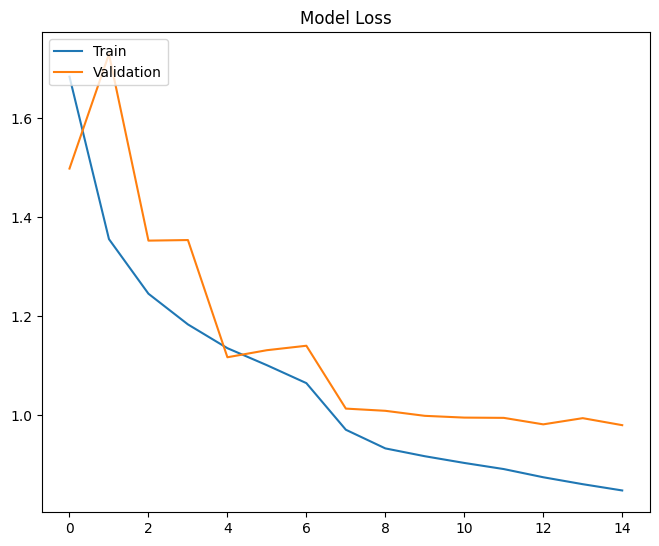

In [22]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.legend(['Train','Validation'], loc= 'upper left')
plt.subplots_adjust(top=1.0,bottom=0.0,right=0.95,left=0.0,hspace=0.25,wspace=0.35)

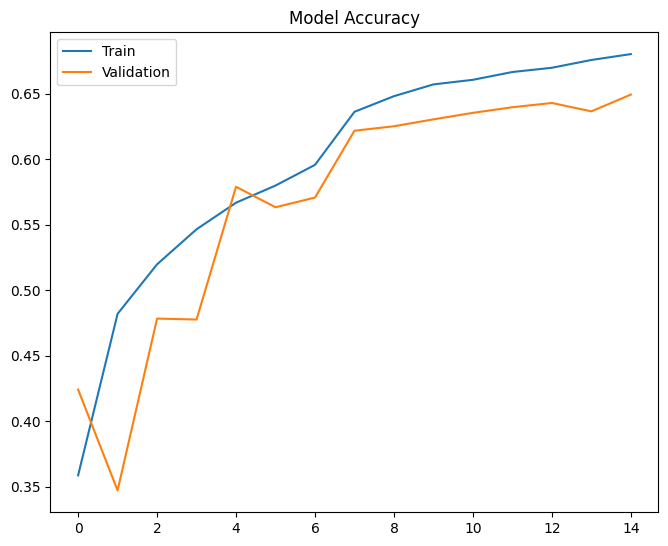

In [23]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.legend(['Train','Validation'], loc= 'upper left')
plt.subplots_adjust(top=1.0,bottom=0.0,right=0.95,left=0.0,hspace=0.25,wspace=0.35)

SAVING MODEL

In [24]:
model_json = model.to_json()
with open("model_a.json","w") as json_file:
    json_file.write(model_json)